# Geographic data - an Introductory Tale

## In this talk I'll give some pointers on how to working with geo data in Python, showing some common **tools** and **data sources**.

### This notebook showcases different kinds of geo-data activities, following a few simple examples.

# Scenario #1:

## Find the nearest river (from a specific location in Israel)

## Step 1: Where is Israel?

We use the GADM database to find the boundaries of Israel.

[GADM](https://gadm.org/download_world.html) is a global database of administrative borders.
You can use it to find the borderlines of countries, counties and cities.

[`fiona`](https://github.com/Toblerity/Fiona) is a great tool to read all kinds of Geographic databases, such as GADM.

We find all GADM's items which are in Israel, and print their type and name.
(Iterating over all of GADM is probably not the most efficient way of doing it but for the sake of simplicity we'll keep it like this)

In [52]:
import fiona
import geojson

israeli_regions = []

with fiona.open('gadm36.gpkg', layer='gadm') as gadm:
    for _, item in gadm.items():
        if item['properties']['NAME_0'] == 'Israel':
            print('{TYPE_1} {NAME_1}'.format(**item['properties']))
            israeli_regions.append(geojson.GeoJSON(item))

/Users/adam/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  import sys


Mehoz Golan
Mehoz HaDarom
Mehoz Haifa
Mehoz HaMerkaz
Mehoz HaZafon
Mehoz Jerusalem
Mehoz Tel Aviv


Each of these items is given as a `GeoJSON` feature - this is one of the most common ways of representing geo data.

Each `Feature` is an object which has `properties` and a `geometry`, which could be a `Point`, a `Line`, a `Polygon` and others.

For example:

In [58]:
tel_aviv = israeli_regions[-1]
tel_aviv['geometry']

{'type': 'MultiPolygon',
 'coordinates': [[[(34.73125076293957, 32.00696182250988),
    (34.73125076293957, 32.007637023925895),
    (34.73152923583996, 32.007637023925895),
    (34.73152923583996, 32.0087509155274),
    (34.73180389404297, 32.0087509155274),
    (34.73180389404297, 32.00958251953119),
    (34.73208236694336, 32.00958251953119),
    (34.73208236694336, 32.010417938232536),
    (34.73236083984375, 32.010417938232536),
    (34.73236083984375, 32.01097106933594),
    (34.73263931274414, 32.01097106933594),
    (34.73263931274414, 32.01180648803711),
    (34.73291778564453, 32.01180648803711),
    (34.73291778564453, 32.01263809204107),
    (34.73319625854492, 32.01263809204107),
    (34.73319625854492, 32.013195037841854),
    (34.733470916748104, 32.013195037841854),
    (34.733470916748104, 32.01430511474621),
    (34.73371505737316, 32.01430892944336),
    (34.733749389648494, 32.01486206054693),
    (34.734027862548885, 32.01486206054693),
    (34.734027862548885, 32.

To quickly view GeoJson files we can use the free [geojson.io] website, either by copy pasting the information or by usign the `geojsonio` package:

In [60]:
import geojsonio
from IPython.display import HTML

def showGeoJson(data):
    url = geojsonio.geojsonio.display(tel_aviv)
    return HTML(f'<a href="{url}" target="_blank">link</a>')

showGeoJson(tel_aviv)

So how do we get the geometry of all of Israel?

We use the powerful package `shapely` - which does many 2D shape manipulations.

In [85]:
from shapely.geometry import shape, mapping
from shapely.ops import unary_union

# Join all the regions into one:
israel = unary_union([shape(i['geometry']) for i in israeli_regions])
# 'Simplify' the object, reducing its complexity and size:
israel = israel.simplify(tolerance=0.01)
# Convert to GeoJson
israel_geojson = mapping(israel)
israel_geojson = geojson.Feature(properties=dict(), geometry=israel_geometry)
israel_geojson

{"geometry": {"coordinates": [[[35.475452, 31.470913], [35.471508, 31.399611], [35.389809, 31.244455], [35.458782, 31.13596], [35.446842, 31.07641], [35.408588, 31.025614], [35.414997, 30.948833], [35.360096, 30.913857], [35.333374, 30.863014], [35.332973, 30.808235], [35.298916, 30.786728], [35.290024, 30.725079], [35.201702, 30.574522], [35.152012, 30.418621], [35.191902, 30.346622], [35.144478, 30.239534], [35.175812, 30.119137], [35.098446, 30.022564], [35.07761, 29.950531], [35.080769, 29.872313], [35.051281, 29.820911], [35.029747, 29.705044], [35.032669, 29.630714], [34.910694, 29.497084], [34.867527, 29.561174], [34.877613, 29.644936], [34.855183, 29.691002], [34.855873, 29.73918], [34.616741, 30.360468], [34.546959, 30.400078], [34.565094, 30.481323], [34.52169, 30.525381], [34.524586, 30.579958], [34.495647, 30.68413], [34.407589, 30.843908], [34.268009, 31.223606], [34.357521, 31.285618], [34.374569, 31.383841], [34.407902, 31.420609], [34.546272, 31.523382], [34.532524, 31.

Note: No political message intended here...

In [81]:
showGeoJson(israel_geojson)

Another option to see it: 

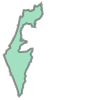

In [107]:
shape(israel)

## Step 2: Find all rivers in Israel

OpenStreetMap is an awesome tool, and all its data is freely available.

See for example, Hayarkon river
[in OpenStreetBrowser](https://www.openstreetbrowser.org/#water/w31991445/details&map=15/32.0997/34.7936&categories=water).

What other options do we have for this? [Let's take a look at the wiki](https://wiki.openstreetmap.org/wiki/Key:waterway#Values).

We want to filter all *line* features for which `waterway=river` or `waterway=stream`.

Luckily, we can download filtered packages of OpenStreetMap from [osmdata](https://download.osmdata.xyz/).

In [116]:
fiona.listlayers('waterway_EPSG4326.gpkg')

['waterway_EPSG4326_point',
 'waterway_EPSG4326_line',
 'waterway_EPSG4326_polygon']

In [119]:
israeli_rivers = []
with fiona.open('waterway_EPSG4326.gpkg', layer='waterway_EPSG4326_line') as waterways:
    rivers = waterways.items(bbox=israel.bounds)
    for _, r in rivers:
        if r['properties']['waterway'] in ('river', 'stream'):
            if r['properties']['name']:
                r_geom = shape(r['geometry'])
                if israel.intersects(r_geom):
                    israeli_rivers.append(r)
israeli_rivers[0]

/Users/adam/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  after removing the cwd from sys.path.


{'type': 'Feature',
 'id': '3559924',
 'properties': OrderedDict([('id', 3566522),
              ('name', 'נחל רמון'),
              ('aerialway', ''),
              ('occupancy', ''),
              ('aerialway_capacity', ''),
              ('aerialway_duration', ''),
              ('aerialway_detachable', ''),
              ('aerialway_bubble', ''),
              ('aerialway_heating', ''),
              ('aerialway_summer_access', ''),
              ('aeroway', ''),
              ('airmark', ''),
              ('operator', ''),
              ('amenity', ''),
              ('barrier', ''),
              ('maxwidth', ''),
              ('width', ''),
              ('maxheight', ''),
              ('height', ''),
              ('wheelchair', ''),
              ('boundary', ''),
              ('admin_level', ''),
              ('border_type', ''),
              ('start_date', ''),
              ('end_date', ''),
              ('fire_boundary', ''),
              ('building', ''),
        

## Step 3: Find the nearest river

In [141]:
# We want to find the nearest river to this location
MY_LOCATION = Point(34.7844446, 31.7606498)

## 1st Attempt - The wrong way to do it:

In [142]:
from shapely.geometry import Point

nearest = None
min_distance = None

for river in israeli_rivers:
    distance = shape(river['geometry']).distance(MY_LOCATION)
    if min_distance is None or min_distance > distance:
        min_distance = distance
        nearest = river

print(min_distance)  # What units???
print(nearest['properties']['name'])

0.0011096987266830058
נחל ברקאי


Why is this wrong?

Distance is using cartesean distances (a.k.a. distance = sqrt((x1-x2)^2 + (y1-y2)^2) ) 

On a sphere it's incorrect - we need to map the coordinates to an approximation of a plane - this is called a projection.

The 'normal' projection looks like this - you can see that the farthest we are from the equator, the more deformed the map becomes.

![Mercator_projection_Square.jpg](Mercator_projection_Square.jpg)

There are tons of different kinds of projections:

![1024px-Comparison_of_Mercator_projections.svg.png](1024px-Comparison_of_Mercator_projections.svg.png)

(all images are CC BY-SA 3.0 and taken from [wikipedia](https://en.wikipedia.org/wiki/Mercator_projection))

We don't really need to understand all of this -

![5755zo.jpg](5755zo.jpg)

## 2nd Attempt - The right way:

We create a projection that's based in our center point - and translate all other coordinates to that reference system:

In [143]:
from pyproj import Transformer
from shapely.ops import transform

# CRS = coordinate reference system
crs = f'+proj=tmerc +lat_0={MY_LOCATION.y} +lon_0={MY_LOCATION.x} +k_0=1 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs'
transformer = Transformer.from_crs('EPSG:4326', crs, always_xy=True)

# Our origin in the new coordinate system
transformed_origin = transform(transformer.transform, MY_LOCATION)
print(mapping(transformed_origin))

{'type': 'Point', 'coordinates': (0.0, 0.0)}


EPSG is a coordinate system index.

EPSG:4326 is the 'regular' lat/lon coordinate system (also known as WGS84) - [see in catalog](http://epsg.io/4326).

In Israel you might find data given in ITM - Israeli TM Grid - aka [EPSG:2039](http://epsg.io/2039)

In [144]:
from shapely.geometry import Point

nearest = None
min_distance = None
for river in israeli_rivers:
    transformed_river = transform(transformer.transform, shape(river['geometry']))
    distance = transformed_river.distance(transformed_origin)
    if min_distance is None or min_distance > distance:
        min_distance = distance
        nearest = river

print(min_distance)  # Units = meters!
print(nearest['properties']['name'])

121.37999435652334
נחל ברקאי


and indeed:

![indeed.png](indeed.png)

Aside - What if we wanted to calculate very long distances?

We can use the `geopy` package

In [153]:
from geopy.distance import distance

WALL_ST = Point(-74.0110143, 40.7060361)

to_wall_st = distance((MY_LOCATION.y, MY_LOCATION.x), (WALL_ST.y, WALL_ST.x))
to_wall_st.kilometers

9160.692624772133

# Scenario 2: Which river is near the most population?

We can find population estimate data in a few locations, such as [WorldPop](https://www.worldpop.org/geodata/summary?id=49808)

This is a different kind of geo file - a raster file.

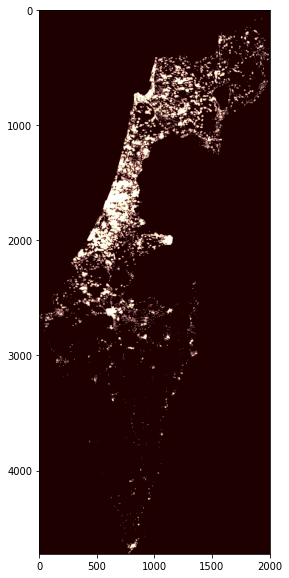

In [161]:
import rasterio
from matplotlib import pyplot

pop = rasterio.open('isr_ppp_2020_constrained.tif', nodata=None)

pyplot.figure(figsize = (10,10))
pyplot.imshow(pop.read(1), cmap='pink')
pyplot.imshow
pyplot.show()

This file is also mapped onto a coordinate system - in our case it's WGS84:

In [162]:
pop.crs

CRS.from_epsg(4326)

We will calculate the estimated amount of people living within a 1km distance of each river. 

We will use the `buffer` method to create a 1km 'buffer' around each of the river's line.

First - we collect all river segments by name:

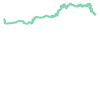

In [210]:
rivers_by_name = dict()
for river in israeli_rivers:
    river_name = river['properties']['name']
    rivers_by_name.setdefault(river_name, []).append(river)
rivers_by_name = dict(
    (name, unary_union([shape(r['geometry']) for r in segments]))
    for name, segments in rivers_by_name.items()
)
sample_river = rivers_by_name['נחל ירקון']
sample_river

Now we do coordinate transformation, apply the buffer and convert again to WGS84:

27.31334838879489


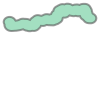

In [214]:
center = sample_river.centroid
crs = f'+proj=tmerc +lat_0={center.y} +lon_0={center.x} +k_0=1 +x_0=0 +y_0=0 +ellps=WGS84 +units=km +no_defs'
transformer = Transformer.from_crs('EPSG:4326', crs, always_xy=True)
inv_transformer = Transformer.from_crs(crs, 'EPSG:4326', always_xy=True)

transformed_sample_river = transform(transformer.transform, sample_river)
print(transformed_sample_river.length)

buffered = transformed_sample_river.buffer(1.0)  # 1 Km Buffer
buffered_wgs84 = transform(inv_transformer.transform, buffered)
buffered_wgs84

In [215]:
from rasterio import mask
masked_pop = mask.mask(pop, [buffered_wgs84], crop=True, nodata=0)
masked_pop = masked_pop[0].squeeze()

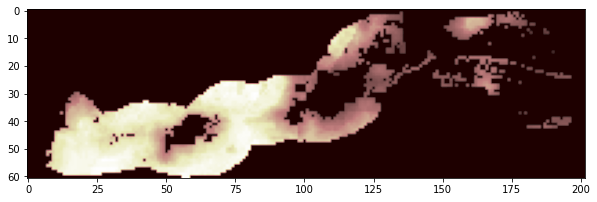

In [216]:
pyplot.figure(figsize = (10,10))
pyplot.imshow(masked_pop, cmap='pink')
pyplot.imshow
pyplot.show()

In [217]:
sum(sum(masked_pop))

176248.05740261078